# Training a custom OCR pipeline with keras-ocr

This is an interactive version of the example documented [here](https://keras-ocr.readthedocs.io/en/latest/examples/end_to_end_training.html).

You may wish to train your own end-to-end OCR pipeline. Here's an example for
how you might do it. Note that the image generator has many options not
documented here (such as adding backgrounds and image augmentation). Check
the documentation for the `keras_ocr.tools.get_image_generator` function for more details.

Please note that, right now, we use a very simple training mechanism for the
text detector which seems to work but does not match the method used in the
original implementation.

In [ ]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install -U opencv-python # We need the most recent version of OpenCV.
%tensorflow_version 2.x

  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-9od8ow8l/keras-ocr_b14316e709d642349b1bdc440d493695
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-9od8ow8l/keras-ocr_b14316e709d642349b1bdc440d493695
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.5 MB 3.8 MB/s 
     |████████████████████████████████| 603 kB 53.0 MB/s 
     |████████████████████████████████| 890 kB 53.5 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.9-py3-none-any.whl size=41435 sha256=d8f1b253e2e5d644c48363bae229194f0c05848d9017844b6de50a75b21546c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-etjepm09/wheels/20/d0/06/ed290995144ec8dde71d3a91d0d590145445c01be60ea70c9b
Successfully built keras-ocr
     |████████████████████████████████| 60.4 MB 1.2 MB/s 


You can mount your Google Drive here if you want -- if not, just change the paths below to remove the `'drive/My Drive'` prefix.

In [ ]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/colab/keras-ocr'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

MessageError: ignored

In [ ]:
data_dir = '.'

In [ ]:
import zipfile
import datetime
import string
import glob
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

assert tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


## Generating synthetic data

First, we define the alphabet that encompasses all characters we want our model to be able to detect and recognize. Below we designate our alphabet as the numbers 0-9, upper- and lower-case letters, and a few puncuation marks. For the recognizer, we will actually only predict lowercase letters because we know some fonts print lower- and upper-case characters with the same glyph.

In order to train on synthetic data, we require a set of fonts and backgrounds. `keras-ocr` includes a set of both of these which have been downloaded from Google Fonts and Wikimedia. The code to generate both of these sets is available in the repository under `scripts/create_fonts_and_backgrounds.py`.

The fonts cover different languages which may have non-overlapping characters. `keras-ocr` supplies a function (`font_supports_alphabet`) to verify that a font includes the characters in an alphabet. We filter to only these fonts. We also exclude any fonts that are marked as `thin` in the filename because those tend to be difficult to render in a legible manner.

The backgrounds folder contains about just over 1,000 image backgrounds.

In [ ]:
alphabet = string.digits + string.ascii_letters + '!?. '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

Looking for ./fonts.zip
Unzipping fonts ZIP file.


Filtering fonts.: 100%|██████████| 2746/2746 [00:27<00:00, 100.23it/s]


Looking for ./backgrounds.zip


With a set of fonts, backgrounds, and alphabet, we now build our data generators.

In order to create images, we need random strings. `keras-ocr` has a simple method for this for English, but anything that generates strings of characters in your selected alphabet will do!

The image generator generates `(image, lines)` tuples where `image` is a HxWx3 image and `lines` is a list of lines of text in the image where each line is itself a list of tuples of the form `((x1, y1), (x2, y2), (x3, y3), (x4, y4), c)`. `c` is the character in the line and `(x1, y2), (x2, y2), (x3, y3),
(x4, y4)` define the bounding coordinates in clockwise order starting from the top left. You can replace this with your own generator, just be sure to match that function signature.

We split our generators into train, validation, and test by separating the fonts and backgrounds used in each.


In [ ]:
text_generator = keras_ocr.data_generation.get_text_generator(alphabet=alphabet)
print(type(text_generator))
print('The first generated text is:', next(text_generator))

def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
image, lines = next(image_generators[0])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

<class 'generator'>
The first generated text is: Tritium. An its weight


error: ignored

Here we build our detector and recognizer models. For both, we'll start with pretrained models. Note that for the recognizer, we freeze the weights in the backbone (all the layers except for the final classification layer).

In [ ]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer
    alphabet=recognizer_alphabet,
    weights='kurapan',
    include_top=False
)
recognizer.compile()
for layer in recognizer.backbone.layers:
    layer.trainable = False

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


We are now ready to train our text detector. Below we use some simple defaults.

- Run training until we have no improvement on the validation set for 5 epochs.
- Save the best weights.
- For each epoch, iterate over all backgrounds one time.

The `detector` object has a `get_batch_generator` method which converts the `image_generator` (which returns images and associated annotations) into a `batch_generator` that returns `X, y` pairs for training with `fit_generator`.

If training on Colab and it assigns you a K80, you can only use batch size 1. But if you get a T4 or P100, you can use larger batch sizes.

In [ ]:
detector_batch_size = 1
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
detector.model.fit_generator(
    generator=detection_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
    epochs=1000,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size)
)

After training the text detector, we train the recognizer. Note that the recognizer expects images
to already be cropped to single lines of text. :code:`keras-ocr` provides a convenience method for
converting our existing generator into a single-line generator. So we perform that conversion.

This image contains: electrom


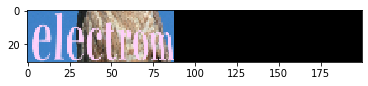

In [ ]:
max_length = 10
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

Just like the `detector`, the :code:`recognizer` has a method for converting the image generator
into a `batch_generator` that Keras' `fit_generator` can use.

We use the same callbacks for early stopping and logging as before.

In [ ]:
recognition_batch_size = 8
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')
recognition_train_generator, recognition_val_generator, recogntion_test_generator = [
    recognizer.get_batch_generator(
      image_generator=image_generator,
      batch_size=recognition_batch_size,
      lowercase=True
    ) for image_generator in recognition_image_generators
]
recognizer.training_model.fit_generator(
    generator=recognition_train_generator,
    epochs=1000,
    steps_per_epoch=math.ceil(len(background_splits[0]) / recognition_batch_size),
    callbacks=[
      tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25),
      tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
      tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / recognition_batch_size),
    workers=0
)

Once training is done, you can use `recognize` to extract text.

Snowcraft and Austrian descent? ['s', 'nowcraft', 'and', 'aus', 'trian', 'descent']


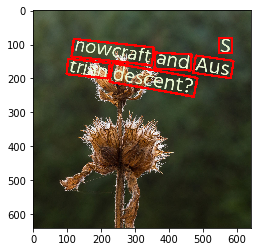

In [ ]:
pipeline = keras_ocr.pipelines.Pipeline(detector=detector, recognizer=recognizer)
image, lines = next(image_generators[0])
predictions = pipeline.recognize(images=[image])[0]
drawn = keras_ocr.tools.drawBoxes(
    image=image, boxes=predictions, boxes_format='predictions'
)
print(
    'Actual:', '\n'.join([' '.join([character for _, character in line]) for line in lines]),
    'Predicted:', [text for text, box in predictions])
plt.imshow(drawn)

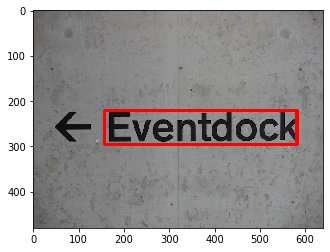

In [ ]:
# !curl https://raw.githubusercontent.com/faustomorales/keras-ocr/master/tests/test_image.jpg --output test_image.jpg
image = keras_ocr.tools.read('test_image.jpg')
boxes = detector.detect(images=[image])[0]
drawn = keras_ocr.detection.drawBoxes(image=image, boxes=boxes)
plt.imshow(drawn)